In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version = 1, as_frame=False)

In [2]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"],mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


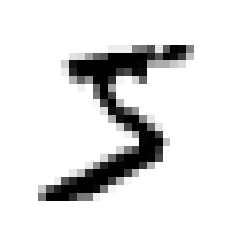

In [4]:
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [5]:
y[0]

'5'

원래는 train set과 test set을 만들때는 모집단에서의 비율을 고려해 만들어야한다.

하지만 mnist data는 사용하기 편하게 미리 비율에 맞춰놔서 나눴기 때문에 그냥 나눈다.

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:],y[:60000],y[60000:]

이진 분류기 만들기

5와 5가 아님을 구분하는 분류기 만들기

데이터를 가져올때 문자로 가져오기 때문에 '5'와 같은지 논리연산을 한다.

In [7]:
y_train_5 = (y_train=='5')
y_test_5 = (y_test == '5')

확률적 경사 하강법을 이용한다.

Stochastic Gradient Desent, SGD

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_classifier = SGDClassifier(random_state=42)
sgd_classifier.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

some_digit에는 y[0]이 들어가있다 그 값은 5 따라서 true가 나올 것이다.

In [9]:
sgd_classifier.predict([some_digit])

array([ True])

폴드가 3개인 k-겹 교차검증을 사용하여 SGDClassifier 모델 평가

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3, random_state = 42, shuffle= True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_classifier)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct /len(y_pred))

0.9669
0.91625
0.96785


cross_val_score 함수를 이용하여 위의 코드를 아래와 같이 간략하게 사용 가능

In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_classifier, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

5가 아닌경우를  예측하는 경우를 교차검증을 사용하여 성능을 측정해보자

내가 찾을 데이터가 전체의 다수가 되면 정확도는 큰 의미없는 값이 된다.

정확도를 성능지표로 선호하지 않는다.

In [14]:
import numpy as np
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
  def fit(self,X,y=None):
    return self

  def predict(self, X):
    return np.zeros((len(X),1),dtype=bool)

never_5_cls = Never5Classifier()
cross_val_score(never_5_cls,X_train,y_train_5,cv=3,scoring="accuracy")  

array([0.91125, 0.90855, 0.90915])

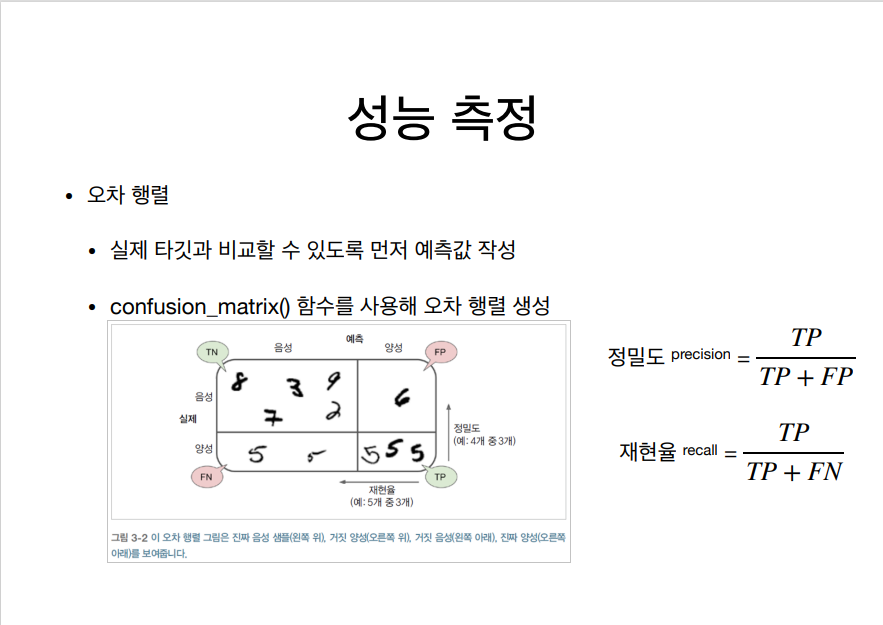

시험에 나올확률 ↑

In [15]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_classifier,X_train,y_train_5,cv=3)
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('Precision score = ', precision_score(y_train_5, y_train_pred))
print('Recall score = ', recall_score(y_train_5, y_train_pred))
print('F1 score = ', f1_score(y_train_5, y_train_pred))

Precision score =  0.8370879772350012
Recall score =  0.6511713705958311
F1 score =  0.7325171197343846


임곗값 지정 예측 

threshold 임계값을 지정해두고 예측한다.

In [19]:
y_scores = sgd_classifier.decision_function([some_digit])
y_scores

array([2164.22030239])

In [20]:
threshold=0
y_some_digit_pred = y_scores > threshold
y_some_digit_pred

array([ True])

In [21]:
threshold=8000
y_some_digit_pred = y_scores > threshold
y_some_digit_pred

array([False])

precision_recall_curve()

In [23]:
y_scores = cross_val_predict(sgd_classifier, X_train, y_train_5, cv=3, method="decision_function")

In [25]:
from sklearn.metrics._plot.precision_recall_curve import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

precisions,recalls, thresholds=precision_recall_curve(y_train_5, y_scores)

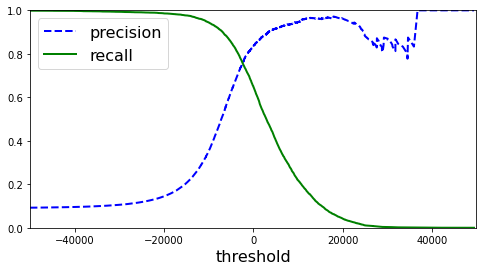

In [26]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="precision", linewidth=2)
  plt.plot(thresholds, recalls[:-1], "g-", label="recall", linewidth=2)
  plt.xlabel("threshold", fontsize=16)
  plt.legend(loc="upper left", fontsize=16)
  plt.ylim([0, 1])
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-50000, 50000])
plt.show()

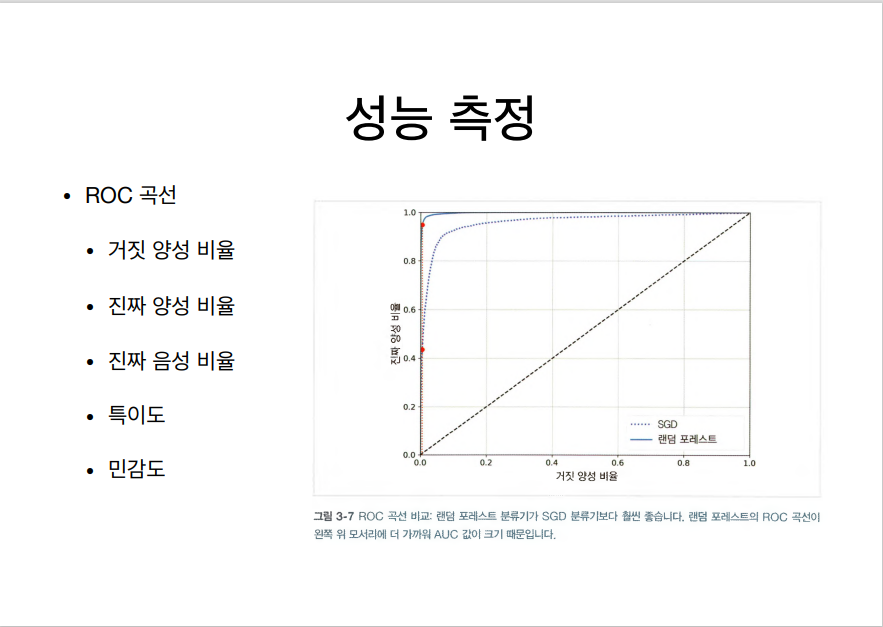

곡선이 벽에 바짝 붙을 수록 좋다 따라서 위 사진에서는 랜덤 포레스트 기법이 SGD보다 좋은것임

다중분류

In [27]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array(['5'], dtype=object)

In [28]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

다중 출력 다중 클래스 분류

이미지에서 잡음을 제거하는 시스템 만들기

data를 불러오기 위한 과정

In [35]:
import matplotlib
import matplotlib.pyplot as plt
def plot_digit(data):
 image = data.reshape(28, 28)
 plt.imshow(image, cmap = matplotlib.cm.binary, interpolation="nearest")
 plt.axis("off")

이미지에 노이즈를 추가한다.



In [38]:
noise = np.random.randint( 0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint( 0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

noise를 제거하고 제거된 이미지를 보여준다.

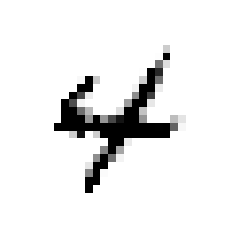

In [39]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[5500]])
plot_digit(clean_digit)